# Water Meter Reading with OpenCV

## Preprocessing

In [3]:
%matplotlib inline
## %matplotlib notebook
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib
print('cv2 version: %s' % cv2.__version__)

cv2 version: 3.1.0


((160, 480), dtype('uint8'))

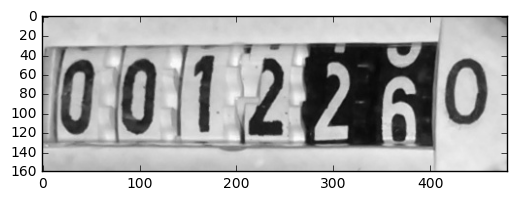

In [4]:
# img_orig = cv2.imread('/Users/yamato/OneDrive/WaterMeterLogs/meter.jpg')
# img_orig = cv2.imread('/Users/yamato/OneDrive/WaterMeterLogs/test-new.jpg')
img_orig = cv2.imread('/Users/yamato/OneDrive/WaterMeterLogs/ocrerror02.jpg')

plt.imshow(img_orig)
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
img.shape, img.dtype

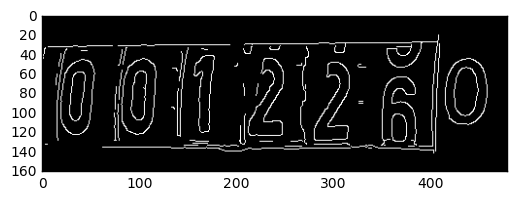

In [5]:
# Canny edge detection
edges = cv2.Canny(img, 200, 250, apertureSize=3, L2gradient=True)
# edges = cv2.Canny(img, 235, 250)
plt.imshow(edges, cmap='gray')

In [6]:
image, contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
contours_dict = dict()
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    area = cv2.contourArea(cont)
    if 10 < area and 10 < w and h > 5:
        contours_dict[(x, y, w, h)] = cont

contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)

In [8]:
len(contours_filtered)

12

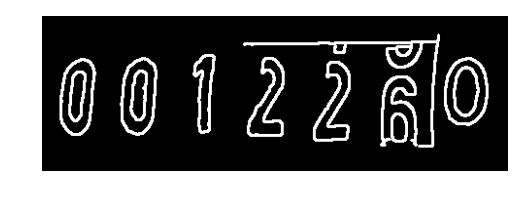

In [9]:
blank_background = np.zeros_like(edges)
img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)
# img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (100,100,100), thickness=cv2.FILLED)
plt.axis('off')
plt.imshow(img_contours, 'gray')

## Isolate Digits

In [13]:
def is_overlapping_horizontally(box1, box2):
    x1, _, w1, _ = box1
    x2, _, _, _ = box2
    if x1 > x2:
        return is_overlapping_horizontally(box2, box1)
    return (x2 - x1) < w1

def merge(box1, box2):
    assert is_overlapping_horizontally(box1, box2)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x = min(x1, x2)
    w = max(x1 + w1, x2 + w2) - x
    y = min(y1, y2)
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def windows(contours):
    """return List[Tuple[x: Int, y: Int, w: Int, h: Int]]"""
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont)
        if not boxes:
            boxes.append(box)
        else:
            if is_overlapping_horizontally(boxes[-1], box):
                last_box = boxes.pop()
                merged_box = merge(box, last_box)
                boxes.append(merged_box)
            else:
                boxes.append(box)
    return boxes

In [14]:
boxes = windows(contours_filtered)
# assert(len(boxes) == 7)   # Expecting 7 digits

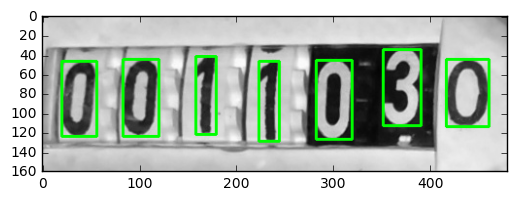

In [15]:
img = img_orig.copy()
for box in boxes:
    x, y, w, h = box
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(img)

## Preparing training data

True

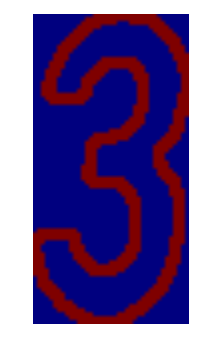

In [16]:
x, y, w, h = boxes[5]
plt.axis('off')
roi = img_contours[y:y+h, x:x+w]
plt.imshow(roi)
cv2.imwrite('testtest.png', roi)

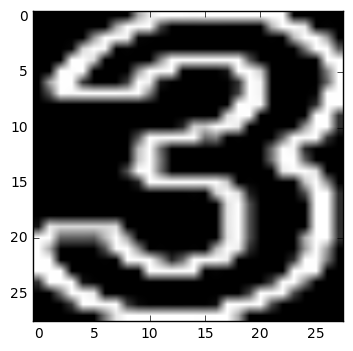

In [17]:
roi = cv2.resize(roi,(28, 28), interpolation = cv2.INTER_CUBIC)
plt.imshow(roi, cmap='gray')

## Preparing raw reading
Prepare a CSV file (`manual_reading.csv`) that has two columns, `Name` and `Reading`. `Name` should correspond to filename without extension (or timestamp of `%(Year)-%(Month)-%(Day)_%(Hour)_%(Minute)_%(digit_place)` format), and `Reading` is human-recognized reading. You can ignore left-padded zeros and the fixed digit (zero) at the rightmost place.

## Split manual entries into digits

In [18]:
import pandas as pd
import itertools as it
import collections

In [19]:
def seven_digits(n):
    return ('%06d' % n) + '0'

names = []
labels = []
df = pd.read_csv('manual_reading.csv')
df['Name'] = df['File'].apply(lambda s: s[:-4])
for (_, basename, reading) in df[['Name', 'Reading']].itertuples():
    digits = seven_digits(reading)
    for i, d in zip(it.count(), digits):
        name = basename + ('_%d' %i)
        names.append(name)
        labels.append(d)

dfout = pd.DataFrame(collections.OrderedDict([('Name', names), ('Label', labels)]))
dfout.to_csv('labels.csv', index=False)

## Generate PNG digit images
Extract digit data from images.

In [15]:
import preprocessor
path = '/Users/yamato/OneDrive/MyCode/WaterMeterReading/trainset_more'
preprocessor.batch(path)

## Shrink PNG into 28x28 pixels with ImageMagick

```
for f in *.png
do
convert $f -resize 28x28 -size 28x28 xc:black +swap -gravity center -composite -depth 8 ../digits/$f
done
```

## Convert images and labels into numpy arrays

In [1]:
import pathlib
import csv
import numpy as np
from PIL import Image

ImportError: No module named 'PIL'

In [17]:
# labels
d = dict()
with open('labels.csv', 'r') as f:
    reader = csv.reader(f)
    for name, label in reader:
        d[name] = label

In [18]:
# images
p = pathlib.Path('.')
image_files = list(p.glob('trainset/*.png'))

In [19]:
def int2vec(n):
    assert 0 <= n <= 9
    res = np.zeros(10)
    res[n] = 1
    return res

In [20]:
labels = [int(d[fpath.stem]) for fpath in image_files]
labels = np.array([int2vec(n) for n in labels])
mat = np.array([np.array(Image.open(fname.as_posix())).flatten() for fname in image_files])
np.save('labels', labels)
np.save('images', mat)

In [21]:
mat.shape

(1211, 784)

In [22]:
idx = 327
img = mat[idx, :]
Image.fromarray(img.reshape(28, 28))

In [23]:
labels[idx]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

## Playgtound

In [24]:
set(edges.ravel())

{0, 255}

In [25]:
# Hough line transform
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLines(img_contours, 1, np.pi/180, 70)
# lines

# for rho, theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
#     cv2.line(edges,(x1,y1),(x2,y2),(0,0,255), 2)

In [26]:
for x in sorted(contours_dict):
    print(x)

(23, 41, 37, 81)
(32, 55, 17, 52)
(87, 39, 38, 84)
(97, 54, 17, 53)
(164, 38, 22, 82)
(222, 43, 37, 84)
(232, 84, 15, 29)
(291, 47, 38, 85)
(301, 60, 17, 58)
(363, 33, 41, 73)
(428, 49, 45, 70)
(437, 58, 27, 52)


In [27]:
len(contours_filtered)

12

((164, 38, 22, 82), 974.5)

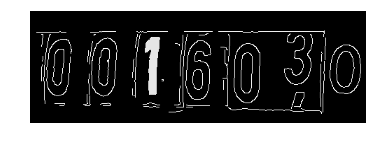

In [28]:
edges_copy = edges.copy()
cont = contours_filtered[4]
img_single_contour = cv2.drawContours(edges_copy, [cont], 0, (230,230,230), cv2.FILLED)

# epsilon = 0.001 * cv2.arcLength(cont, True)
# cont_approx = cv2.approxPolyDP(np.append(cont, [cont[0]], axis=0), epsilon, True)

plt.axis('off')
plt.imshow(img_single_contour, cmap='gray')
cv2.boundingRect(cont), cv2.contourArea(cont, True)